___
# Simulación de escenarios de desescalada con el modelo SIR-D
___


En este notebook se realiza una simulación de desescalada por edades utilizando el modelo SIR-D para epidemias.

## Importo librerías:

In [1]:
from funcs import *

In [2]:
# Semilla aleatoria
np.random.seed(2019)
# Pandas
pd.set_option("display.max_colwidth", 1000)
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (12, 6)

# Concepto teórico: Modelo SIR-D
Debido a que estamos midiendo el número de casos fatales y de casos recuperados por separado, podemos utilizar dos variables ("Recuperados" y "Muertes") en lugar de "Recuperados + Muertes" en el modelo matemático.

 ### ¿Qué es el modelo SIR-D?
* S: Susceptible
* I: Infectado
* R: Recuperado
* D: Muertes

Modelo:  
\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

$\alpha$: Tasa de mortalidad [1/min]  
$\beta$: Tasa de contacto efectiva [1/min]  
$\gamma$: Tasa de recuperación [1/min]  

Ecuación diferencial ordinaria:
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I  \\
\end{align*}

Donde $N=S+I+R+D$ es la población total, $T$ es el tiempo transcurrido desde la fecha de inicio.

### Modelo SIR-D no dimensional 
Set $(S, I, R, D) = N \times (x, y, z, w)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

Esto resulta en que las ecuaciones diferenciales son:  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y  \\
\end{align*}

Donde $N$ es la población total y $\tau$ es un coeficiente ([min], es un entero para simplificar).  

El rango de variables y parámetros:  
\begin{align*}
& 0 \leq (x, y, z, w, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

El número de reproducción puede definirse como  
\begin{align*}
R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}
\end{align*}

Valores medios estimados de $R_0$:  
$R_0$ ("R nada") significa "el número medio de infecciones secundarias causadas por un huésped infectado".  
2.06: Zika en América del Sur, 2015-2016  
1,51: Ebola en Guinea, 2014  
1,33: Gripe H1N1 en Sudáfrica, 2009  
3.5 : El SRAS en 2002-2003  
1,68: Gripe H2N2 en EE.UU., 1957  
3.8 : Ola de otoño de la gripe española de 1918 en Génova  
1.5 : Ola de primavera de 1918 de la gripe española en Génova  

Primero de todo descargo la pirámide poblacional de España, para saber cuantas personas hay de cada edad en el país. El virus ataca más en edades avanzadas. Los datos de la pirámide poblacional se han obtenido de https://www.populationpyramid.net/es/espa%C3%B1a/2019/.
Por otro lado, también se ha hecho uso de la tasa de mortalidad por edades obtenido de https://coronavirus-resumen.herokuapp.com/.

<img src='tasa_mortalidad.png'></img>

In [3]:
edades = pd.read_csv('./data/piramide_2019.csv') 
poblacion_total = edades['Hombres'].sum() + edades['Mujeres'].sum()
edades[:3]

,Edad,Hombres,Mujeres,Tasa mortalidad
0,0-4,1038501,977680,0.05
1,5-9,1198575,1125661,0.05
2,10-14,1276540,1195708,0.20


In [4]:
print(u'La población total en España es de {} personas'.format(poblacion_total))

La población total en España es de 46736782 personas


___
# 1.- Desescalada con apertura total:
___

Por ejemplo, establece $R_0 = 2.5, \kappa=0.005, \rho=0.2$ y los valores iniciales $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [5]:
#(numero reproductivo, tasa mortalidad * tau, tasa efectiva contagio * tau)
r0, kappa, rho = (2.5, 0.005, 0.2) 
sigma = rho / r0 - kappa
# (susceptibles, infectados, recuperados, fallecidos)
initials = (0.999, 0.001, 0, 0) 
display(Markdown(rf"$\kappa = {kappa},\ \rho = {rho},\ \sigma = {sigma}$."))

$\kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

Suponemos que el día inicial es el 5 de Mayo de 2020. $\tau=1440$ minutos y abrimos al total de la población $N=46.736.782$.

In [6]:
tau = 1440
dia_inicial = datetime.datetime(2020, 5, 5)
poblacion = poblacion_total

In [7]:
%%time
df = simulation(SIRD, initials, step_n=200, kappa=kappa, rho=rho, sigma=sigma)
df.tail()

CPU times: user 12.9 ms, sys: 498 µs, total: 13.4 ms
Wall time: 29.9 ms


,t,x,y,z,w
196,196,0.106463,0.000205,0.837499,0.055833
197,197,0.106459,0.000193,0.837514,0.055834
198,198,0.106455,0.000182,0.837528,0.055835
199,199,0.106451,0.000172,0.837541,0.055836
200,200,0.106448,0.000162,0.837553,0.055837


In [8]:
ori_df = pd.DataFrame(
    {
        "Date": (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + dia_inicial,
        "Group": "Stopping",
        "País": "España",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (df["y"] * poblacion).astype(np.int64)
    }
)
ori_df["Recovered"] = (df["z"] * poblacion).astype(np.int64)
ori_df["Deaths"] = (df["w"] * poblacion).astype(np.int64)
ori_df["Confirmed"] = ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
ori_df["Susceptible"] = poblacion - ori_df["Confirmed"]
ori_df.tail()

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
196,2020-11-17,Stopping,España,-,4975759,41761023,9567,39141990,2609466
197,2020-11-18,Stopping,España,-,4975562,41761220,9021,39142687,2609512
198,2020-11-19,Stopping,España,-,4975375,41761407,8507,39143344,2609556
199,2020-11-20,Stopping,España,-,4975199,41761583,8022,39143964,2609597
200,2020-11-21,Stopping,España,-,4975034,41761748,7564,39144548,2609636


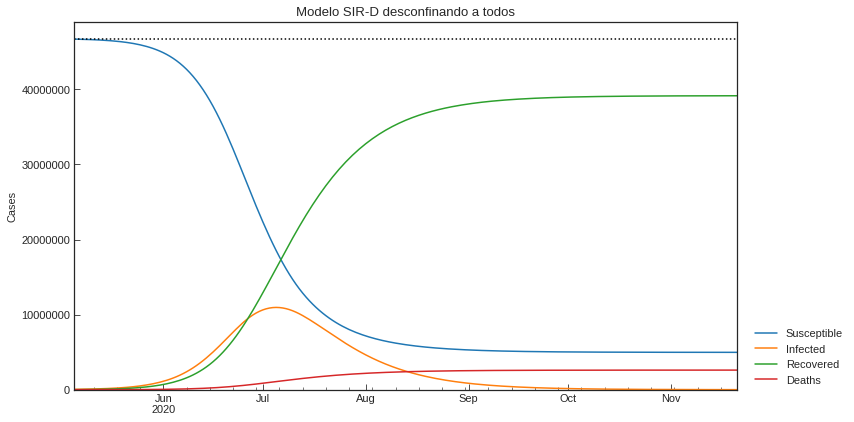

El número total de fallecimientos es de: 2609636
Fallece un 5.58 % de la población


In [9]:
line_plot(
    ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Modelo SIR-D desconfinando a todos",
    h=poblacion,
    y_integer=True
)
print(u'El número total de fallecimientos es de: {}'.format(ori_df['Deaths'].max()))
print(u'Fallece un {} % de la población'.format(np.round((ori_df['Deaths'].max()/poblacion)*100,2)))

# 2.- Desescalada por edades
___

## 2.1.- Apertura a < 50 años:
___

In [10]:
poblacion_menor_50 = edades.loc[edades['Tasa mortalidad']<=0.5][['Hombres', 'Mujeres']].sum().sum()
poblacion_menor_50

27768675

Establecemos $R_0 = 2.5, \kappa=0.0004, \rho=0.2$ y los valores iniciales $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [11]:
 #(numero reproductivo, tasa mortalidad * tau, tasa efectiva contagio * tau)
r0, kappa, rho = (2.5, 0.0004, 0.2)
sigma = rho / r0 - kappa
# (susceptibles, infectados, recuperados, fallecidos)
initials = (0.999, 0.001, 0, 0) 
display(Markdown(rf"$\kappa = {kappa},\ \rho = {rho},\ \sigma = {sigma}$."))

$\kappa = 0.0004,\ \rho = 0.2,\ \sigma = 0.0796$.

Suponemos que el día inicial es el 5 de Mayo de 2020. $\tau=1440$ minutos y abrimos a la población de menos de 50 años.

In [12]:
tau = 1440
dia_inicial = datetime.datetime(2020, 5, 5)
poblacion = poblacion_menor_50

In [13]:
%%time
df = simulation(SIRD, initials, step_n=90, kappa=kappa, rho=rho, sigma=sigma)
df.tail()

CPU times: user 4.42 ms, sys: 38 µs, total: 4.46 ms
Wall time: 4.28 ms


,t,x,y,z,w
86,86,0.159565,0.109474,0.727306,0.003655
87,87,0.156190,0.104299,0.735813,0.003698
88,88,0.153043,0.099303,0.743915,0.003738
89,89,0.150106,0.094490,0.751627,0.003777
90,90,0.147365,0.089858,0.758963,0.003814


In [14]:
ori_df = pd.DataFrame(
    {
        "Date": (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + dia_inicial,
        "Group": "Stopping",
        "País": "España",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (df["y"] * poblacion).astype(np.int64)
    }
)
ori_df["Recovered"] = (df["z"] * poblacion).astype(np.int64)
ori_df["Deaths"] = (df["w"] * poblacion).astype(np.int64)
ori_df["Confirmed"] = ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
ori_df["Susceptible"] = poblacion - ori_df["Confirmed"]
ori_df.tail()

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
86,2020-07-30,Stopping,España,-,4430903,23337772,3039953,20196330,101489
87,2020-07-31,Stopping,España,-,4337201,23431474,2896240,20432558,102676
88,2020-08-01,Stopping,España,-,4249802,23518873,2757522,20657545,103806
89,2020-08-02,Stopping,España,-,4168249,23600426,2623853,20871691,104882
90,2020-08-03,Stopping,España,-,4092124,23676551,2495248,21075397,105906


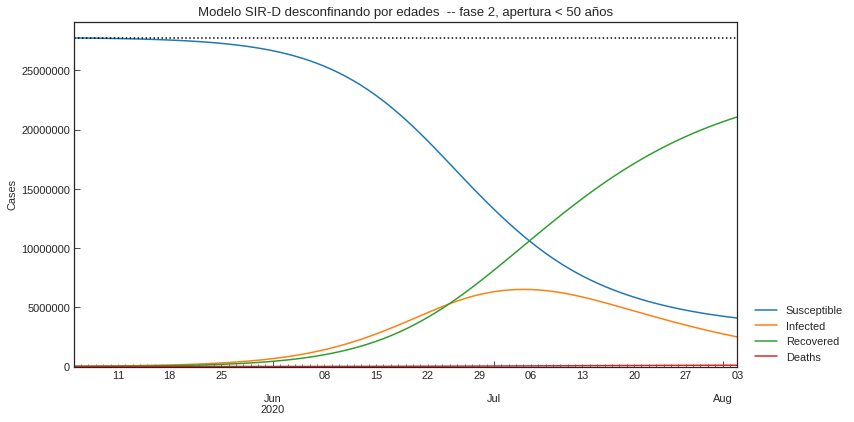

El número total de fallecimientos es de: 105906
Fallece un 0.38 % de la población


In [15]:
line_plot(
    ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Modelo SIR-D desconfinando por edades  -- fase 2, apertura < 50 años",
    h=poblacion,
    y_integer=True
)
print(u'El número total de fallecimientos es de: {}'.format(ori_df['Deaths'].max()))
print(u'Fallece un {} % de la población'.format(np.round((ori_df['Deaths'].max()/poblacion)*100,2)))

## 2.2.- Apertura a >= 50 y <70 años:
___

In [16]:
poblacion_mayor_50_menor_70 = edades.loc[(edades['Tasa mortalidad']>1) &
                               (edades['Tasa mortalidad']<4)][['Hombres', 'Mujeres']].sum().sum()
poblacion_mayor_50_menor_70

12145105

In [17]:
condicion_inicial = ori_df.loc[ori_df['Date']==ori_df['Date'].max()]
condicion_inicial

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
90,2020-08-03,Stopping,España,-,4092124,23676551,2495248,21075397,105906


In [18]:
susceptibles = poblacion_mayor_50_menor_70 + condicion_inicial['Susceptible'].values[0]
infectados = condicion_inicial['Infected'].values[0]
recuperados = condicion_inicial['Recovered'].values[0]
fallecidos = condicion_inicial['Deaths'].values[0]

In [19]:
ini_sus = susceptibles/(susceptibles+infectados+recuperados+fallecidos)
ini_inf = infectados/(susceptibles+infectados+recuperados+fallecidos)
ini_recup = recuperados/(susceptibles+infectados+recuperados+fallecidos)
ini_fall = fallecidos/(susceptibles+infectados+recuperados+fallecidos)
ini_sus, ini_inf, ini_recup, ini_fall

(0.4068075987791685,
 0.06251595313698677,
 0.5280230787462376,
 0.002653369337607212)

Ahora aumentamos la tasa de mortalidad esperada, ya que el nuevo grupo es más mayor: $R_0 = 2.5, \kappa=0.003, \rho=0.2$.

In [20]:
#(numero reproductivo, tasa mortalidad * tau, tasa efectiva contagio * tau)
r0, kappa, rho = (2.5, 0.003, 0.2) 
sigma = rho / r0 - kappa
 # (susceptibles, infectados, recuperados, fallecidos)
initials = (ini_sus, ini_inf, ini_recup, ini_fall)
display(Markdown(rf"$\kappa = {kappa},\ \rho = {rho},\ \sigma = {sigma}$."))

$\kappa = 0.003,\ \rho = 0.2,\ \sigma = 0.077$.

Suponemos que el día inicial es el 3 de Agosto de 2020. $\tau=1440$ minutos y abrimos también a la población de entre 50 y 70 años.

In [21]:
tau = 1440
dia_inicial = datetime.datetime(2020, 8, 3)
poblacion = susceptibles + infectados + recuperados + fallecidos

In [22]:
%%time
df = simulation(SIRD, initials, step_n=90, kappa=kappa, rho=rho, sigma=sigma)
df.tail()

CPU times: user 4.06 ms, sys: 2 µs, total: 4.07 ms
Wall time: 3.58 ms


,t,x,y,z,w
86,86,0.225987,0.008051,0.754485,0.011477
87,87,0.225632,0.007775,0.755092,0.011500
88,88,0.225290,0.007509,0.755679,0.011523
89,89,0.224959,0.007251,0.756245,0.011545
90,90,0.224639,0.007001,0.756794,0.011567


In [23]:
ori_df = pd.DataFrame(
    {
        "Date": (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + dia_inicial,
        "Group": "Stopping",
        "País": "España",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (df["y"] * poblacion).astype(np.int64)
    }
)
ori_df["Recovered"] = (df["z"] * poblacion).astype(np.int64)
ori_df["Deaths"] = (df["w"] * poblacion).astype(np.int64)
ori_df["Confirmed"] = ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
ori_df["Susceptible"] = poblacion - ori_df["Confirmed"]
ori_df.tail()

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
86,2020-10-28,Stopping,España,-,9020007,30893773,321344,30114356,458073
87,2020-10-29,Stopping,España,-,9005841,30907939,310344,30138579,459016
88,2020-10-30,Stopping,España,-,8992164,30921616,299701,30161987,459928
89,2020-10-31,Stopping,España,-,8978954,30934826,289403,30184613,460810
90,2020-11-01,Stopping,España,-,8966184,30947596,279440,30206493,461663


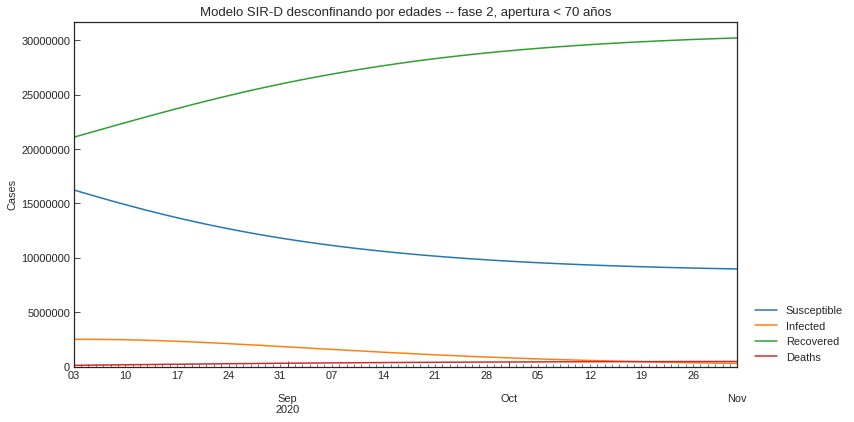

El número total de fallecimientos es de: 461663
Fallece un 1.16 % de la población


In [24]:
line_plot(
    ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Modelo SIR-D desconfinando por edades -- fase 2, apertura < 70 años",
    h=poblacion,
    y_integer=True
)
print(u'El número total de fallecimientos es de: {}'.format(ori_df['Deaths'].max()))
print(u'Fallece un {} % de la población'.format(np.round((ori_df['Deaths'].max()/poblacion)*100,2)))

## 2.3.- Apertura a >= 70:
___

In [25]:
poblacion_mayor_70 = edades.loc[(edades['Tasa mortalidad']>4)][['Hombres', 'Mujeres']].sum().sum()
poblacion_mayor_70

6823002

In [26]:
condicion_inicial = ori_df.loc[ori_df['Date']==ori_df['Date'].max()]
condicion_inicial

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
90,2020-11-01,Stopping,España,-,8966184,30947596,279440,30206493,461663


In [27]:
susceptibles = poblacion_mayor_70 + condicion_inicial['Susceptible'].values[0]
infectados = condicion_inicial['Infected'].values[0]
recuperados = condicion_inicial['Recovered'].values[0]
fallecidos = condicion_inicial['Deaths'].values[0]

In [28]:
ini_sus = susceptibles/(susceptibles+infectados+recuperados+fallecidos)
ini_inf = infectados/(susceptibles+infectados+recuperados+fallecidos)
ini_recup = recuperados/(susceptibles+infectados+recuperados+fallecidos)
ini_fall = fallecidos/(susceptibles+infectados+recuperados+fallecidos)
ini_sus, ini_inf, ini_recup, ini_fall

(0.3378321168967089,
 0.005979016698239943,
 0.6463109291521183,
 0.009877937252932819)

Volvemos a subir la tasa de mortalidad $R_0 = 2.5, \kappa=0.005, \rho=0.2$.

In [29]:
r0, kappa, rho = (2.5, 0.005, 0.2) #(numero reproductivo, tasa mortalidad * tau, tasa efectiva contagio * tau)
sigma = rho / r0 - kappa
initials = (ini_sus, ini_inf, ini_recup, ini_fall) # (susceptibles, infectados, recuperados, fallecidos)
display(Markdown(rf"$\kappa = {kappa},\ \rho = {rho},\ \sigma = {sigma}$."))

$\kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

Suponemos que el día inicial es el 1 de Noviembre de 2020. $\tau=1440$ minutos y abrimos al total de la población.

In [30]:
tau = 1440
dia_inicial = datetime.datetime(2020, 11, 1)
poblacion = susceptibles + infectados + recuperados + fallecidos

In [31]:
%%time
df = simulation(SIRD, initials, step_n=20, kappa=kappa, rho=rho, sigma=sigma)
df.tail()

CPU times: user 2.56 ms, sys: 0 ns, total: 2.56 ms
Wall time: 2.24 ms


,t,x,y,z,w
16,16,0.332039,0.004854,0.652797,0.010310
17,17,0.331719,0.004788,0.653159,0.010334
18,18,0.331404,0.004723,0.653515,0.010358
19,19,0.331093,0.004658,0.653867,0.010382
20,20,0.330787,0.004594,0.654214,0.010405


In [32]:
ori_df = pd.DataFrame(
    {
        "Date": (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + dia_inicial,
        "Group": "Stopping",
        "País": "España",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (df["y"] * poblacion).astype(np.int64)
    }
)
ori_df["Recovered"] = (df["z"] * poblacion).astype(np.int64)
ori_df["Deaths"] = (df["w"] * poblacion).astype(np.int64)
ori_df["Confirmed"] = ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
ori_df["Susceptible"] = poblacion - ori_df["Confirmed"]
ori_df.tail()

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
16,2020-11-17,Stopping,España,-,15518442,31218340,226837,30509631,481872
17,2020-11-18,Stopping,España,-,15503489,31233293,223767,30526528,482998
18,2020-11-19,Stopping,España,-,15488752,31248030,220725,30543196,484109
19,2020-11-20,Stopping,España,-,15474229,31262553,217711,30559637,485205
20,2020-11-21,Stopping,España,-,15459916,31276866,214725,30575854,486287


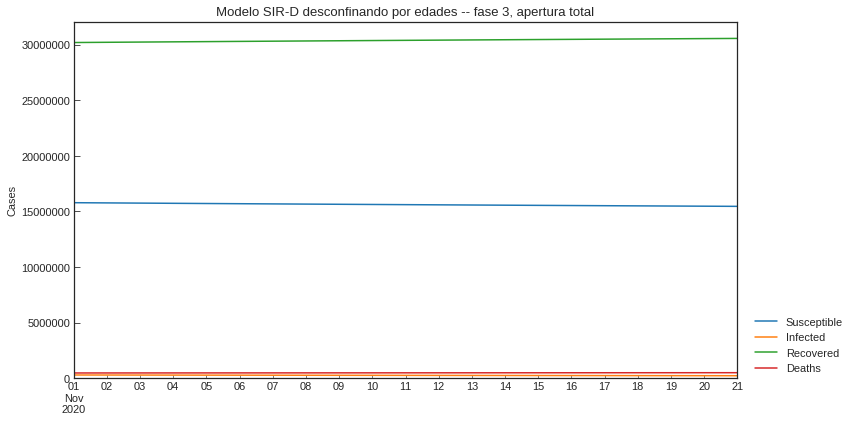

El número total de fallecimientos es de: 486287
Fallece un 1.04 % de la población


In [33]:
line_plot(
    ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Modelo SIR-D desconfinando por edades -- fase 3, apertura total",
    h=poblacion,
    y_integer=True
)
print(u'El número total de fallecimientos es de: {}'.format(ori_df['Deaths'].max()))
print(u'Fallece un {} % de la población'.format(np.round((ori_df['Deaths'].max()/poblacion)*100,2)))